In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the drive

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

%load_ext autoreload

### Load modules

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDistDDE_with_adjoint_accel as nddde
import src.bio_eqn_case.bio_eqn_modcall as bio
from src.bio_eqn_case.Bio_Eqn_Helper_Classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shutil import move
import pickle
import scipy as sc
from scipy import signal

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

## Load data

In [4]:
os.chdir(basedir)
    
with open(os.path.join('neuralClosureModels/final_paper_scripts', 'nODE_C2i_Exp3_predictions.pkl'), 'rb') as output:
    nODE_dict = pickle.load(output)

In [5]:
t = tf.concat([nODE_dict['t'], nODE_dict['val_t']], axis=0)

nnpzd = tf.concat([nODE_dict['true_x_low_complex'], nODE_dict['val_true_x_low_complex']], axis=0)

npz = tf.concat([nODE_dict['x_low_complex'], nODE_dict['val_x_low_complex']], axis=0)


## Plot RMSE 

In [6]:
def compute_xcorr(sig1, sig2):
    corr_list = []
    for i in range(3): 
        corr = signal.correlate(sig1[:, i], sig2[:, i]) 
        corr /= np.max(corr)
        corr_list.append(np.expand_dims(corr, axis=-1))
        
    corr_list = np.concatenate(corr_list, axis=-1)
    corr = np.mean(corr_list, axis=-1)
    lags = signal.correlation_lags(len(sig1[:, 0]), len(sig2[:, 0]))
    return corr, lags

In [7]:
npz.numpy().shape

(6590, 1, 3)

In [37]:
corr_npz, lag = compute_xcorr(npz.numpy()[0:1200, 0, :], npz.numpy()[0:1200, 0, :])
corr_nnpzd, lag = compute_xcorr(nnpzd.numpy()[0:1200, 0, :], nnpzd.numpy()[0:1200, 0, :])

lag = lag * (30./600)

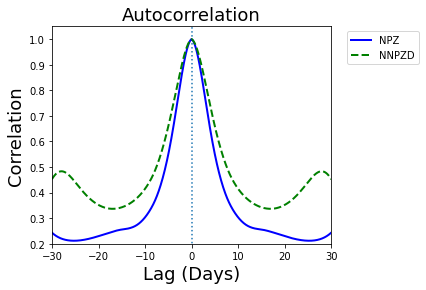

In [38]:
diff_colors = ['b', 'g', 'r', 'k', 'c', 'm']
rom_dims = 3

fig = plt.figure(figsize=(5, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Autocorrelation', fontsize=18)
ax.set_xlabel('Lag (Days)', fontsize=18)
ax.set_ylabel('Correlation', fontsize=18)
ax.set_ylim(0.2, 1.05)

ax.plot(lag, corr_npz, 'b'+'-', label = 'NPZ ', linewidth=2)
ax.plot(lag, corr_nnpzd, 'g'+'--', label = 'NNPZD', linewidth=2)
ax.vlines(0., 0.0, 1.05, colors=None, linestyles='dotted')

ax.set_xlim(-600 * (30./600), 600 * (30./600))

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show() 

In [10]:
os.chdir(basedir)
    
with open(os.path.join('neuralClosureModels/final_paper_scripts', 'bseline_Exp2.pkl'), 'rb') as output:
    exp2_dict = pickle.load(output)

In [11]:
t = exp2_dict['t_lowres']

u_lowres = exp2_dict['u_lowres']

u_lowres_interp_highres = exp2_dict['u_lowres_interp_highres']

In [12]:
u_lowres.shape

TensorShape([500, 25])

In [42]:
corr_u_lowres, lag = compute_xcorr(u_lowres.numpy()[0:250, :], u_lowres.numpy()[0:250, :])
corr_u_lowres_interp_highres, lag = compute_xcorr(u_lowres_interp_highres[0:250, :], u_lowres_interp_highres[0:250, :])

lag = lag * (1/100)

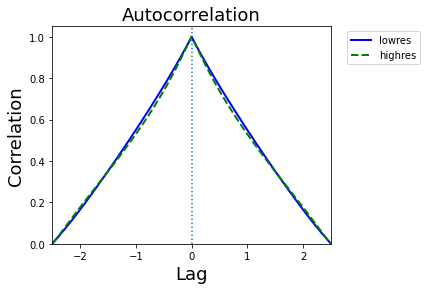

In [43]:
diff_colors = ['b', 'g', 'r', 'k', 'c', 'm']
rom_dims = 3

fig = plt.figure(figsize=(5, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Autocorrelation', fontsize=18)
ax.set_xlabel('Lag', fontsize=18)
ax.set_ylabel('Correlation', fontsize=18)
ax.set_ylim(0.0, 1.05)

ax.plot(lag, corr_u_lowres, 'b'+'-', label = 'lowres ', linewidth=2)
ax.plot(lag, corr_u_lowres_interp_highres, 'g'+'--', label = 'highres', linewidth=2)
ax.vlines(0., 0.0, 1.05, colors=None, linestyles='dotted')

ax.set_xlim(-250 * (1/100), 250 * (1/100))

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()